In [1]:
#Reference: https://towardsdatascience.com/machine-learning-text-classification-language-modelling-using-fast-ai-b1b334f2872d

In [2]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
     |████████████████████████████████| 704.8MB 26kB/s 


In [3]:
import pandas as pd
import csv
import os
from keras.preprocessing.text import text_to_word_sequence
import pandas as pd
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.preprocessing import sequence
from io import StringIO
import nltk 
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D, Bidirectional,LSTM, SpatialDropout1D

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
#Load the data csv from google drive
review_data = pd.read_csv('/content/tripadvisor_hotel_reviews.csv')
print(review_data.shape)
review_data.head()

(20491, 2)


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
review_data['Review'].replace(' ', np.nan, inplace=True)
print(review_data['Review'].isnull().sum())
review_data['Rating'].replace(' ', np.nan, inplace=True)
print(review_data['Rating'].isnull().sum())

0
0


In [6]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [7]:
review_data['Review']

0        nice hotel expensive parking got good deal sta...
1        ok nothing special charge diamond member hilto...
2        nice rooms not 4* experience hotel monaco seat...
3        unique, great stay, wonderful time hotel monac...
4        great stay great stay, went seahawk game aweso...
                               ...                        
20486    best kept secret 3rd time staying charm, not 5...
20487    great location price view hotel great quick pl...
20488    ok just looks nice modern outside, desk staff ...
20489    hotel theft ruined vacation hotel opened sept ...
20490    people talking, ca n't believe excellent ratin...
Name: Review, Length: 20491, dtype: object

In [8]:
review_data = review_data[['Rating', 'Review']]
review_data

,Rating,Review
0,4,nice hotel expensive parking got good deal sta...
1,2,ok nothing special charge diamond member hilto...
2,3,nice rooms not 4* experience hotel monaco seat...
3,5,"unique, great stay, wonderful time hotel monac..."
4,5,"great stay great stay, went seahawk game aweso..."
...,...,...
20486,5,"best kept secret 3rd time staying charm, not 5..."
20487,4,great location price view hotel great quick pl...
20488,2,"ok just looks nice modern outside, desk staff ..."
20489,1,hotel theft ruined vacation hotel opened sept ...


Data Preprocessing

In [9]:
df_trn, df_val = train_test_split(review_data, stratify = review_data['Rating'], test_size = 0.2, random_state = 12)

In [10]:
print(df_trn.shape, df_val.shape)

(16392, 2) (4099, 2)


In [11]:
df_trn

,Rating,Review
4641,2,"nice food nice service shame tatty rooms, disa..."
10913,5,"fantastic hotel, fantastic hotel just returned..."
1030,5,great boutique hotel enjoyed 4 nights kensingt...
18633,4,"wonderful place married vacation, recently ret..."
10691,4,"good location bigger rooms spacious nice, quie..."
...,...,...
2578,4,"days el conquistador lovely resort things, day..."
13910,2,value money scale worst hotel stayed high end ...
13016,5,loved spent weeks sirenis cocotal resort domin...
14609,3,good location new carpets stayed july 2008. st...


Language Model

In [12]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
#data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32, data_lm.save('tmp_lm')

In [13]:
data_lm.show_batch()

idx,text
0,", not expect paying odds got apples bottle looked like tap water small chocolates food restaurant divine hugely expensive definitely odds expect pay 150 euros not meal , decor restaurant bar reception area faultless slightly xxunk atmosphere hotel bit thing morning breakfast not necessarily relaxing experiences , real lack facilities terms spa pool told dealing xxunk probably not stay afraid , understand change management hotel called dylan likely improve things"
1,"room , extremely large room 3 beds large bedroom double bed new bathroom , ceilings high beautiful old fresco paintings , furnishings lovely , complaint street noise morning noticable facing suite double windows , a / c worked , owner gassim extremely friendly helpful really fussed guests , family nice breakfast great espresso machine use , clean internet free , location convenient walking florence exception bus piazza michaelangelo fantastic views"
2,"pool areas beautiful large hot tubs plenty space enjoy privacy water warm clean , husband golfed faldo course great experience , did n't opportunity eat resort did advantage nearby restaurants , great shooping nearby , loved resort ca n't wait return , xxbos rated husband travelled quite extensively caribbean , time say resort definately not worthy 4 star rating , grounds nice kept tidy , hotel tired , supposed king"
3,"fabulous historic hotel modern amenities superb service , really enjoyed stay fairmont , xxbos moaning , stayed hotel visit barcelona.the location superb , ca nt better location.the hotel clean tidy , basic fairly xxunk good i m going xxunk hotel want hassle free stay xxunk fine ignore moaning , hotel great value money , xxbos dreams punta cana entertainment entertainment excellent , cast performers wonderful , singers dancers terrific ,"
4,"yum , valet parking pricey parking sydney dear , hotel room tastefully decorated modern style , room light dimmers romantic large showers / bath , loved pillow menu , definately stay , xxbos fantastic hotel english - speakers great location great choice mid - level hotel beijing , rooms clean bathrooms really nice , want explore city use room showering sleeping place , staff extremely friendly helpful , not people"


In [14]:
data_lm.save('tmp_lm')

In [15]:
learn = language_model_learner(data_lm,arch = AWD_LSTM,  drop_mult=0.2)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02
Min loss divided by 10: 4.37E-02


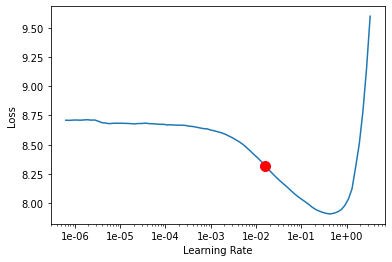

In [16]:
learn.lr_find()
learn.recorder.plot(suggestion = True)
min_grad_lr = learn.recorder.min_grad_lr

In [17]:
learn.fit_one_cycle(3,min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,6.041275,5.863979,0.162893,02:10
1,5.715822,5.693713,0.172132,02:13
2,5.297459,5.639596,0.175849,02:14


Fine tune the language model

In [18]:
learn.unfreeze()
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.110915,5.558740,0.182131,02:39
1,4.943082,5.526165,0.185531,02:39
2,4.640637,5.589995,0.183538,02:39


In [19]:
learn.predict('room is', n_words=5)

'room is nt special came hotel i'

In [20]:
learn.save_encoder('fine_enc')
#learn.load_encoder('ft_enc')

Creating the classifier

In [21]:
# Classifier model data
data_clas = TextClasDataBunch.from_df('./', train_df=df_trn, valid_df=df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [22]:
# Classifier
classifier = text_classifier_learner(data_clas, drop_mult=0.3, arch=AWD_LSTM)
classifier.load_encoder('fine_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (16392 items)
x: TextList
xxbos nice food nice service shame tatty rooms , disappointment , having familiar xxunk london stayed five - star hotels europe expecting lot , friendly staff welcoming lovely ginger lemongrass concoction slightly downhill , room superficially nice need redecoration paint coming furnishings looked worn closer xxunk no choice pillows feather not ideal suffer allergies , offered choice pillows star hotels past , nothing complimentary hotel mini - bar price tag , not expect paying odds got apples bottle looked like tap water small chocolates food restaurant divine hugely expensive definitely odds expect pay 150 euros not meal , decor restaurant bar reception area faultless slightly xxunk atmosphere hotel bit thing morning breakfast not necessarily relaxing experiences , real lack facilities terms spa pool told dealing xxunk probably not stay afraid , understand change management hotel called dylan likely improv

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 6.31E-02


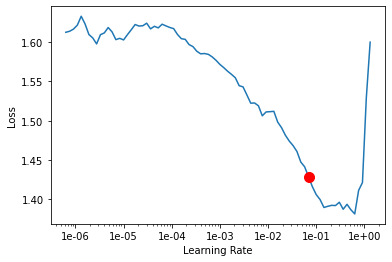

In [23]:
classifier.lr_find()
classifier.recorder.plot(suggestion = True)
min_grad_lr1 = classifier.recorder.min_grad_lr

In [24]:
classifier.fit_one_cycle(5,min_grad_lr1)

epoch,train_loss,valid_loss,accuracy,time
0,1.034768,0.909079,0.582337,01:05
1,1.004970,0.965968,0.577458,00:55
2,0.979390,0.859070,0.621127,01:01
3,0.980222,1.123389,0.624543,01:04
4,0.942528,0.825808,0.632349,00:56


Fine tuning the classifier

In [25]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(5,min_grad_lr1)

epoch,train_loss,valid_loss,accuracy,time
0,0.984988,0.968539,0.570139,01:07
1,1.062708,1.164754,0.496219,01:09
2,0.921634,1.537032,0.627714,01:04
3,0.912124,1.298050,0.642840,01:14
4,0.887154,4.127235,0.649183,01:13


In [26]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(5, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.892619,3.768545,0.644547,01:16
1,0.827313,1.421412,0.651866,01:18
2,0.858274,1.283587,0.654062,01:18
3,0.851497,2.045090,0.653086,01:18
4,0.847846,1.859637,0.655770,01:05
